In [25]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import cmath
import scipy.signal as spsig
# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'w'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 8
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 800
# plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.cmap'] = 'viridis'

res = 300
MC_N = int(1e4)
peakVals = 1

# parameters

In [26]:
Delta_ZPL_0 = 406.83  # 406 THz  Meesala
lambda_SO_gs = 46e-3  # 46 GHz  Meesala
lambda_SO_es = 255e-3  # 255 GHz  Meesala

t_para = -1.7e3  # -1.7 PHz/strain  Meesala
t_perp = 0.078e3  # 0.078 PHz/strain   Meesala
d_gs = 1.3e3  # 1.3 PHz/strain   Meesala
d_es = 1.8e3  # 1.8 PHz/strain   Meesala
f_gs = -1.7e3  # -1.7 PHz/strain   Meesala
f_es = -3.4e3 # -3.4 PHz/strain   Meesala

StdDev_direc = 4e-4
StdDev_shear = 1e-4

# StdDev_direc = 2.5e-4
# StdDev_shear = 2.5e-4

gamma_10 = 1.33e-3  # 28 GHz p.3 or 1.33 Ghz p.5 Smallwood PRL
# gamma_10 = 1e-4 # fwhm = 10e-3 Kelsey

poi = -0.2  # Poisson ratio of diamond, Kelsey

# nu_t_min = 402.25
# nu_t_max = 409.5

# nu_t_min = 405.5
# nu_t_max = 408.75

# nu_t_min = Delta_ZPL_0-lambda_SO_es+lambda_SO_gs - 3.
# nu_t_max = Delta_ZPL_0-lambda_SO_es+lambda_SO_gs + 3.

# nu_t_min = Delta_ZPL_0 - 0.5
# nu_t_max = Delta_ZPL_0 + 0.5

nu_t_min = 406.5
nu_t_max = 407.1

# nu_t_min = -0.5
# nu_t_max = 0.5

nu_t = np.linspace(nu_t_min, nu_t_max, res)
nu_tau = np.linspace(-nu_t_max, -nu_t_min, res)

# R_couple_Floor = 2.
# R_couple_Depth = 1.
# R_couple_StdDev = 0.5
# Gamma_10 = 1.

R_couple_Floor = 1e3
R_couple_Depth = 1.
# R_couple_StdDev = StdDev_direc
# R_couple_StdDev = 6e-5
R_couple_StdDev_direc = 1e-4
R_couple_StdDev_shear = 5e-5
Gamma_10 = 1.

# colorbar function

In [27]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

# creating mesh

In [28]:
nu_t_mesh, nu_tau_mesh = np.meshgrid(nu_t, nu_tau, indexing='xy')

# multiple plot function

In [29]:
# @numba.jit
def slices_plots(
    databox,
    titles=None,
    figure_shape=[4, 4],
    figure_size=(11, 10),
    vertical_gap=0.15,
    horizontal_gap=0.15,
    shared_x_label=r'Third-order frequency, $\nu_t$ (THz)',
    shared_x_label_x_position=0.515,
    shared_x_label_y_position=0.09,
    shared_y_label=r'First-order frequency, $\nu_\tau$ (THz)',
    shared_y_label_x_position=0.08,
    shared_y_label_y_position=0.5,
    shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\nu_t, \nu_\tau) \right\}$',
    shared_title_x_position=0.515,
    shared_title_y_position=0.93,
    share_x_axis=True,
    share_y_axis=True,
    colorbar_labels='arb. units',
    EXTENT=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau))):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(databox[i],
                                    origin='lower',
                                    extent=EXTENT)
        ax.flatten()[i].set_title(titles[i])

        if np.size(colorbar_labels) == 1:
            if (i + 1) % figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5 * SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

# complex square function

In [30]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

# complex phase

In [31]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def phase(x):

    return cmath.phase(x)

In [32]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

In [33]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_gs**2.,
            4. * (d_gs * (eps_xx - eps_yy) + f_gs * eps_yz)**2.,
            4. * (-2. * d_gs * eps_xy + f_gs * eps_zx)**2.
        ]))

In [34]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_es**2.,
            4. * (d_es * (eps_xx - eps_yy) + f_es * eps_yz)**2.,
            4. * (-2. * d_es * eps_xy + f_es * eps_zx)**2.
        ]))

\begin{equation}\label{eq:1}
R(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = R_{floor} \left(1 - R_{depth} \, e^{\frac{-\epsilon_{xx}^2 - \epsilon_{yy}^2 - \epsilon_{zz}^2}{2 {\sigma}^2}} e^{\frac{-\epsilon_{yz}^2 - \epsilon_{xy}^2 - \epsilon_{zx}^2}{2 {\sigma}^2}} \right)
\end{equation}


In [35]:
@numba.jit
def R_couple(eps_xx=0, 
             eps_yy=0, 
             eps_zz=0, 
             eps_yz=0, 
             eps_xy=0, 
             eps_zx=0):

    return R_couple_Floor * (1. - R_couple_Depth 
                             * np.exp(-(eps_xx**2. + eps_yy**2. + eps_zz**2.) / 2. / R_couple_StdDev_direc**2.) 
                             * np.exp(-(eps_yz**2. + eps_xy**2. + eps_zx**2.) / 2. / R_couple_StdDev_shear**2.))

\begin{equation}\label{eq:2}
B(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \frac{\Gamma_{10}}{\Gamma_{10} + R(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx})}
\end{equation}

In [36]:
@numba.jit
def Branch(eps_xx=0, 
           eps_yy=0, 
           eps_zz=0, 
           eps_yz=0, 
           eps_xy=0, 
           eps_zx=0):

    Gamma_12 = R_couple(eps_xx, 
                        eps_yy, 
                        eps_zz, 
                        eps_yz, 
                        eps_xy, 
                        eps_zx)
    
    branch = Gamma_10 / (Gamma_10 + Gamma_12)
#     branch -= np.min(branch)
#     branch /= np.max(branch)

    return branch

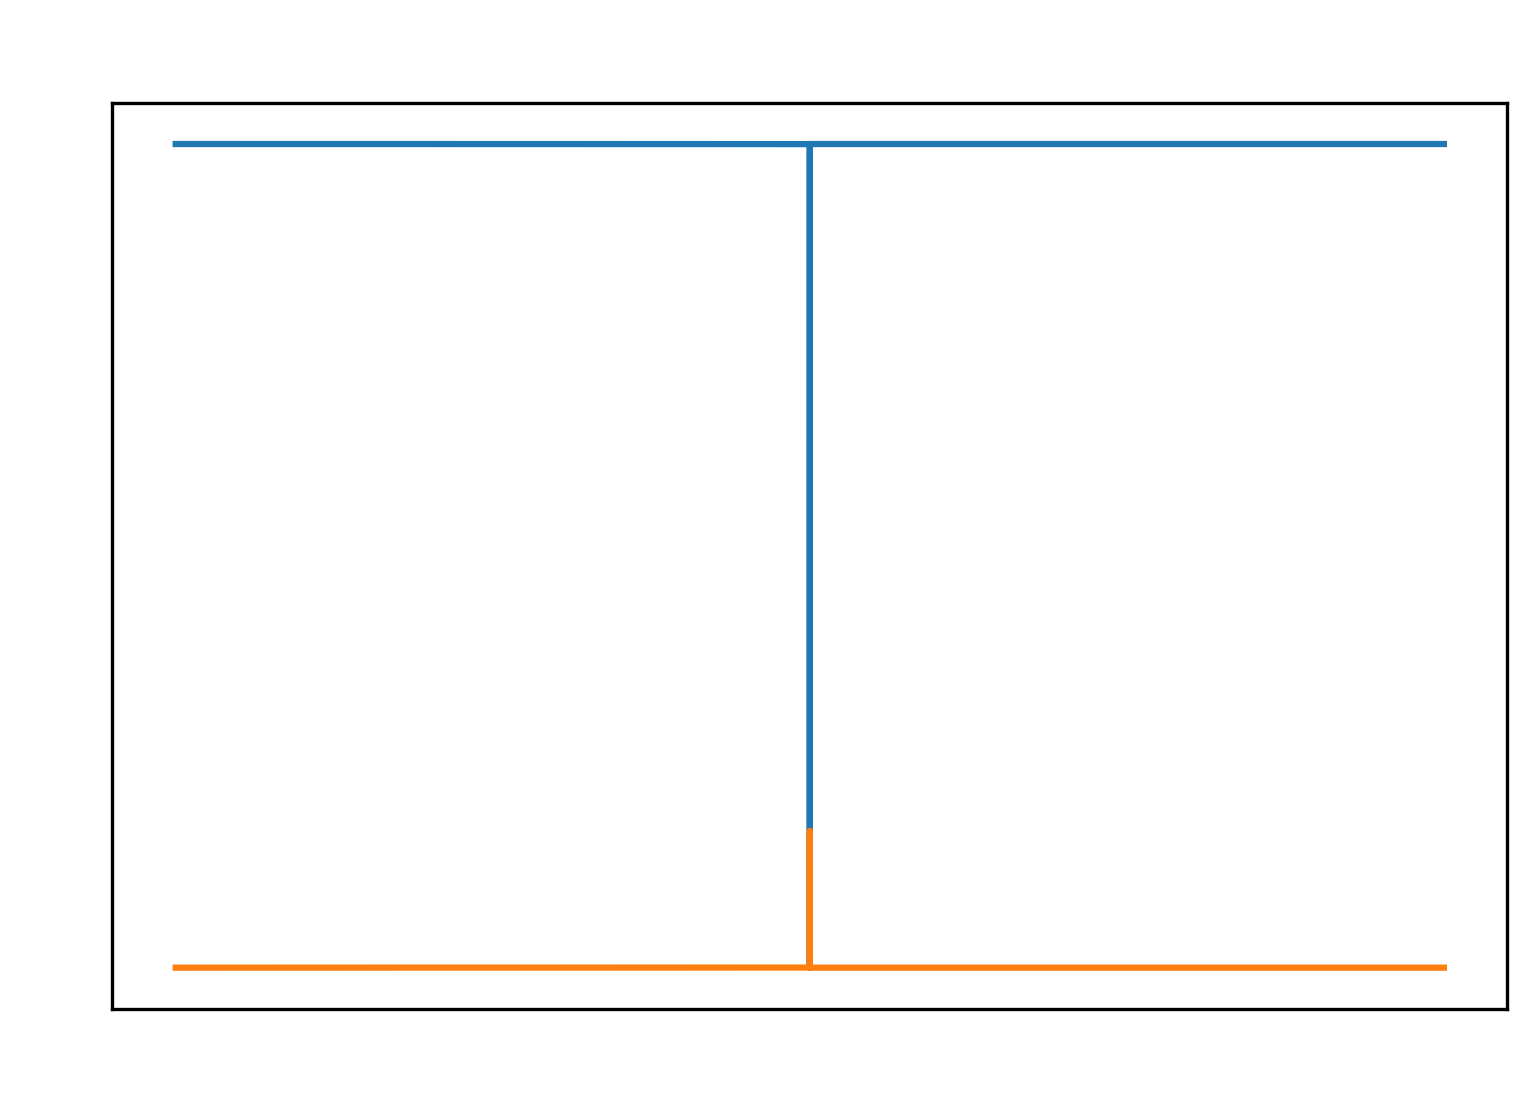

In [37]:
xvals = np.linspace(-1e1, 1e1, 1000000)
yvals = R_couple(xvals)
# yvals /= np.max(yvals)

plt.figure()
plt.plot(xvals, yvals/np.max(yvals))
plt.plot(xvals, 1./(1.+yvals))
plt.title(
    r'$B(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \frac{\Gamma_{10}}{\Gamma_{10} + R(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx})}$'
)
plt.show()

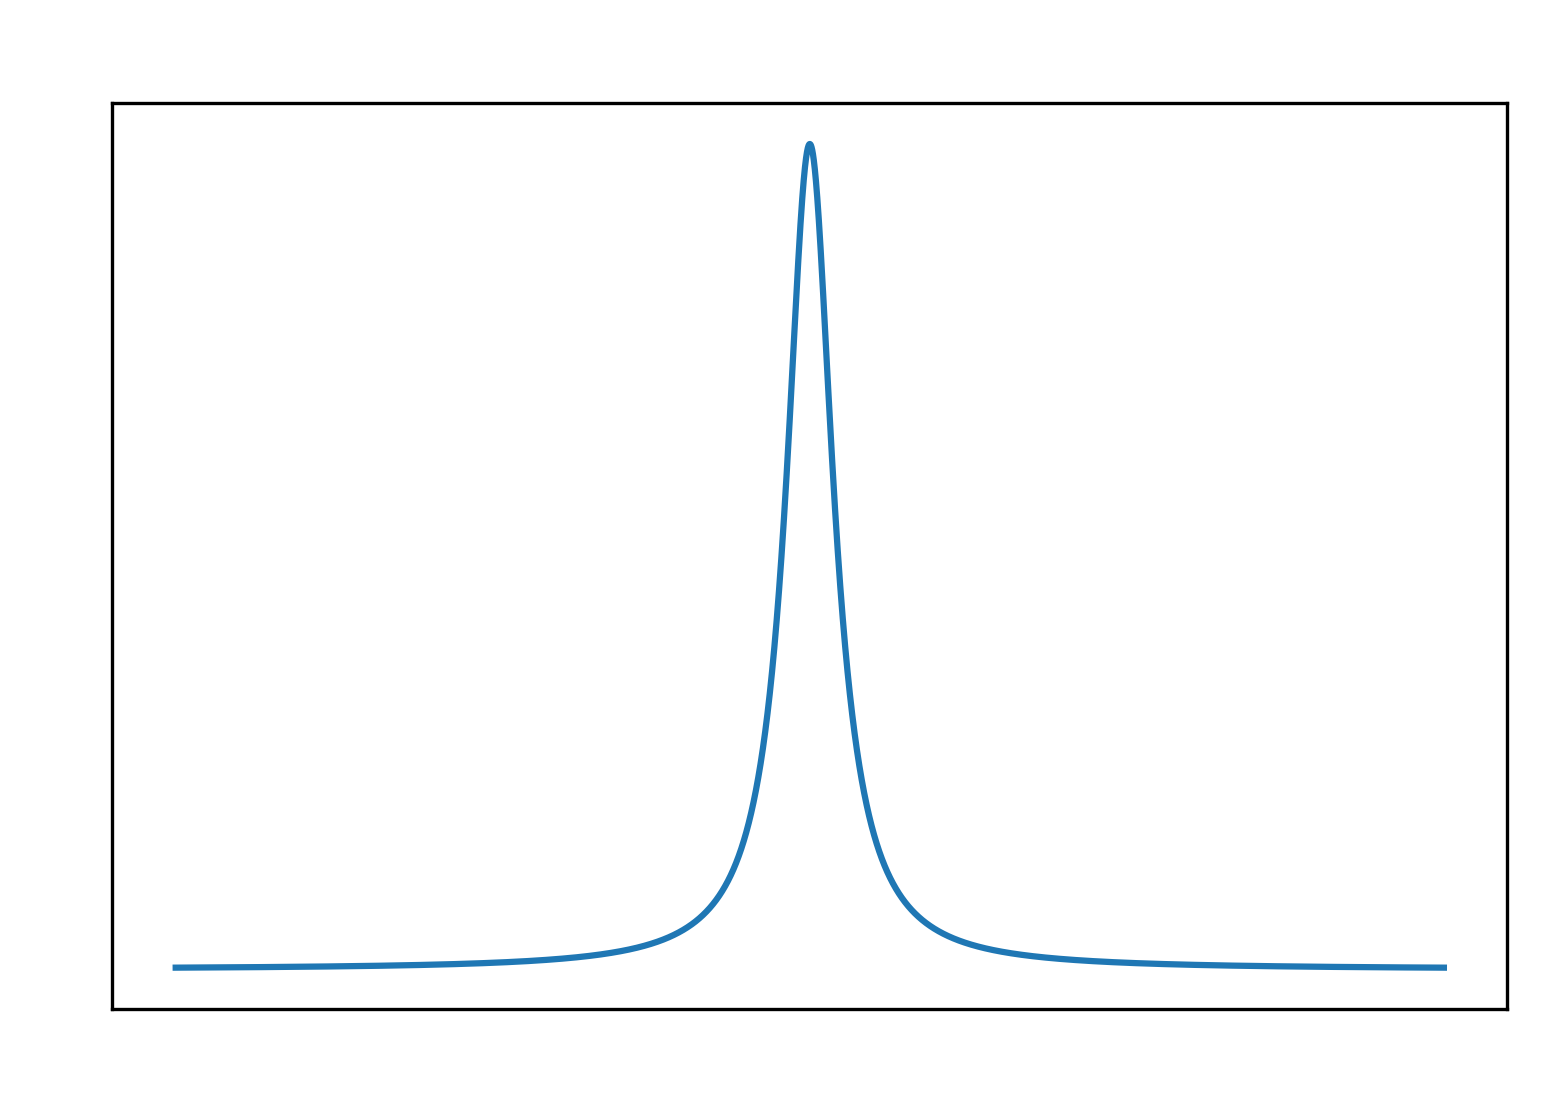

In [38]:
xvals = np.linspace(-1e-4, 1e-4, 1000000)
yvals = Branch(xvals)
# yvals /= np.max(yvals)

plt.figure()
plt.plot(xvals, yvals)
plt.title(
    r'$B(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx}) = \frac{\Gamma_{10}}{\Gamma_{10} + R(\epsilon_{xx}, \epsilon_{yy}, \epsilon_{zz}, \epsilon_{yz}, \epsilon_{xy}, \epsilon_{zx})}$'
)
plt.show()

In [39]:
@numba.jit
def rho(nu_t,
        nu_tau,
        eps_xx=0.,
        eps_yy=0.,
        eps_zz=0.,
        eps_yz=0.,
        eps_xy=0.,
        eps_zx=0.):

    Del_ZPL = Delta_ZPL(eps_xx, eps_yy, eps_zz)

    Del_gs = Delta_gs(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    Del_es = Delta_es(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    if peakVals:
    
        amp = np.array(
            [0.0938, 0.0833, 0.0579, 0.0576,
             0.0709, 1.0000, 0.0799, 0.1521, 
             0.0631, 0.0837, 0.3036, 0.0737, 
             0.0522, 0.1212, 0.0581, 0.1228])

    else:
    
        amp = np.array(
            [1., 1., 1., 1., 
             1., 1., 1., 1., 
             1., 1., 1., 1., 
             1., 1., 1., 1.])

    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.],
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.], 
                     [ 1., -1.,  1., -1.],
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.],
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.], 
                     [-1.,  1., -1.,  1.],
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.],
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])

    RHO = 1.j * np.zeros(np.shape(nu_t))

    for i in range(np.shape(sign)[0]):
        t_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            nu_t - (Del_ZPL + sign[i, 0]*Del_gs/2. + sign[i, 1]*Del_es/2. -
                       1.j * gamma_10))
        tau_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            nu_tau + (Del_ZPL + sign[i, 2]*Del_gs/2. + sign[i, 3]*Del_es/2. +
                         1.j * gamma_10))

        RHO += t_Lorentz * tau_Lorentz

    return RHO

In [40]:
@numba.jit
def rand6_MCint(
        nu_t=nu_t,
        nu_tau=nu_tau,
        MC_N=MC_N  # MC Steps
):

    randn_eps = np.random.randn(6, MC_N)  # normal distribution
    randn_eps[:3] *= StdDev_direc
    randn_eps[3:] *= StdDev_shear

    I_rand6 = 1.j * np.zeros((res, res))
    I_rand6_unbranch = 1.j * np.zeros((res, res))


    if MC_N >= res**2:

        # looping over nu mesh, equivalent to the below, tends to be faster if MC_N > res^2
        for i, om_t in enumerate(nu_t):
            for j, om_tau in enumerate(nu_tau):
                I_rand6[j, i] = np.mean(
                    Branch(randn_eps[0], 
                           randn_eps[1], 
                           randn_eps[2], 
                           randn_eps[3], 
                           randn_eps[4], 
                           randn_eps[5]) * rho(om_t, 
                                           om_tau, 
                                           randn_eps[0], 
                                           randn_eps[1], 
                                           randn_eps[2], 
                                           randn_eps[3], 
                                           randn_eps[4], 
                                           randn_eps[5])
                )
                I_rand6_unbranch[j, i] = np.mean(rho(om_t, 
                                            om_tau, 
                                            randn_eps[0], 
                                            randn_eps[1], 
                                            randn_eps[2], 
                                            randn_eps[3], 
                                            randn_eps[4], 
                                            randn_eps[5])
                                       )

    else:

        # looping over MC stemp, equivalent to the top, tends to be faster if MC_N < res^2
        for i in range(MC_N):
            I_rand6 += Branch(randn_eps[0, i], 
                              randn_eps[1, i], 
                              randn_eps[2, i], 
                              randn_eps[3, i], 
                              randn_eps[4, i], 
                              randn_eps[5, i]) * rho(nu_t_mesh, 
                                              nu_tau_mesh, 
                                              randn_eps[0, i], 
                                              randn_eps[1, i], 
                                              randn_eps[2, i], 
                                              randn_eps[3, i], 
                                              randn_eps[4, i], 
                                              randn_eps[5, i])
            I_rand6_unbranch += rho(nu_t_mesh, 
                           nu_tau_mesh, 
                           randn_eps[0, i], 
                           randn_eps[1, i], 
                           randn_eps[2, i], 
                           randn_eps[3, i], 
                           randn_eps[4, i], 
                           randn_eps[5, i])

    return I_rand6 / np.sqrt(np.max(abs2(I_rand6))), I_rand6_unbranch / np.sqrt(np.max(abs2(I_rand6_unbranch)))
#     return I_rand6

In [41]:
I_random6, I_random6_unbranch = rand6_MCint()

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_966/2561822251.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rand6_MCint" failed type inference due to: Invalid use of type(CPUDispatcher(<function rho at 0x7f9d1ebcfd30>)) with parameters (float64, float64, array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C), array(float64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function rho at 0x7f9d1ebcfd30>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_966/2561822251.py (27)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_966/2561822251.py", line 27:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_966/2561822251.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Fun

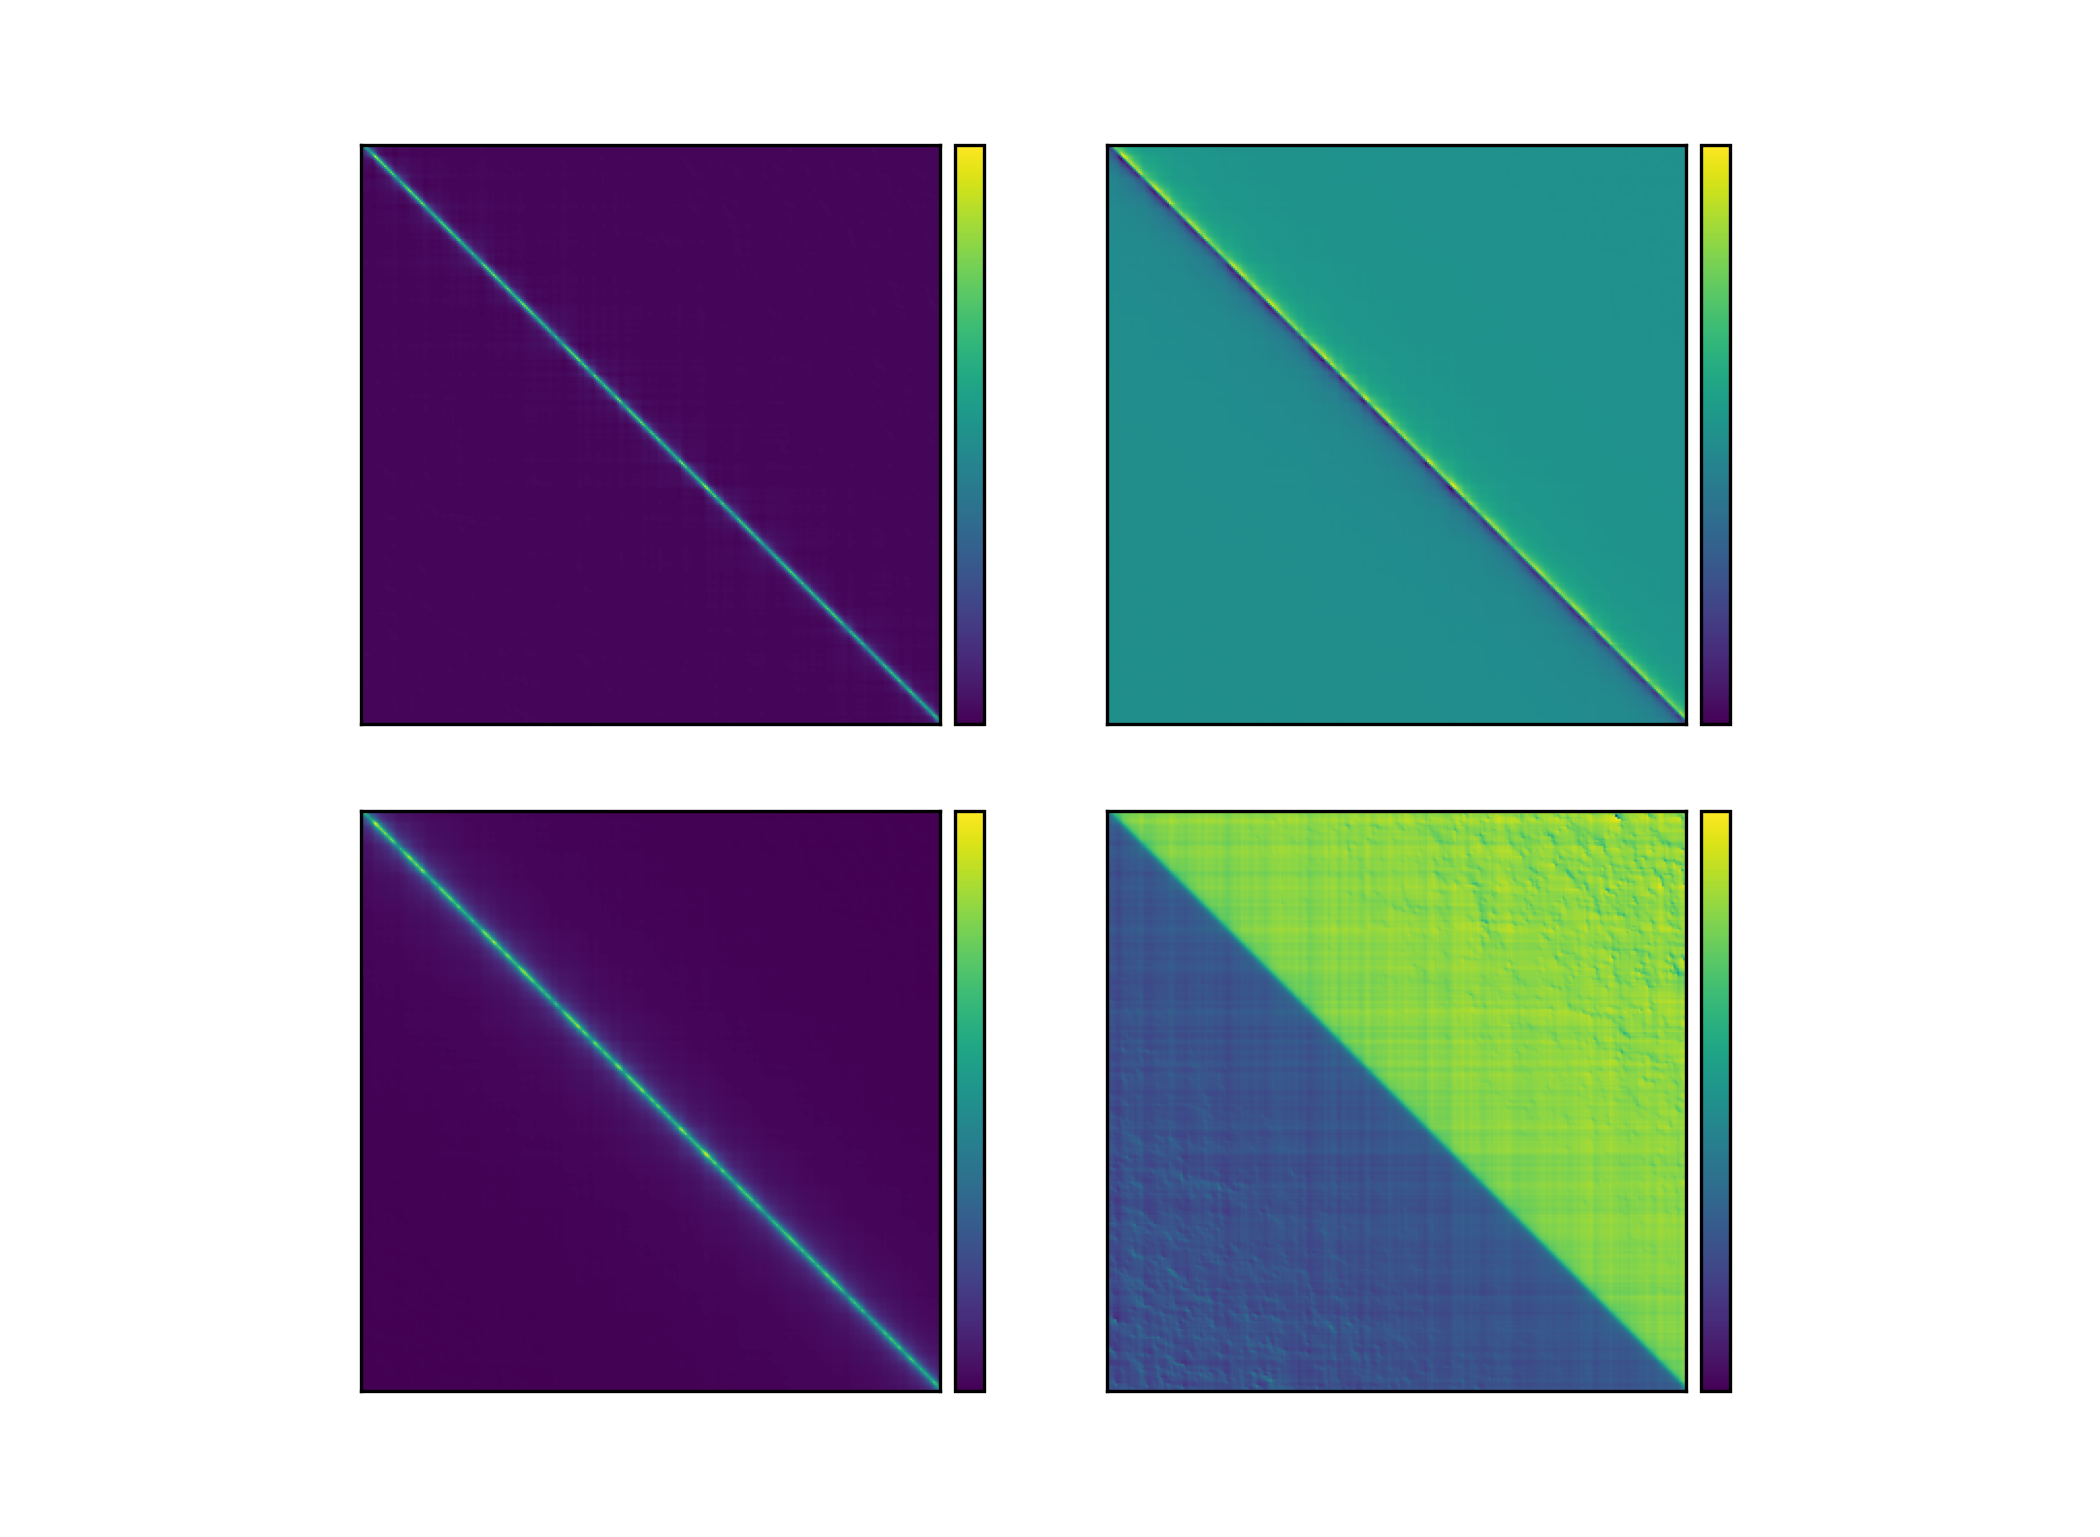

In [42]:
minPlt = 406.5   # THz
maxPlt = 407.1  # THz

# minPlt = nu_t_min   # THz
# maxPlt = nu_t_max  # THz

minInd_t = np.argmin(np.abs(nu_t-minPlt))
maxInd_t = np.argmin(np.abs(nu_t-maxPlt))

minInd_tau = np.argmin(np.abs(nu_tau+maxPlt))
maxInd_tau = np.argmin(np.abs(nu_tau+minPlt))

I_random6Plt = I_random6[minInd_tau:maxInd_tau,minInd_t:maxInd_t]

I_random6_ReImAmPh = np.array([I_random6Plt.real, 
                               I_random6Plt.imag, 
                               np.sqrt(abs2(I_random6Plt)), 
                               phase(I_random6Plt)])

fig_random6 = slices_plots(I_random6_ReImAmPh, 
                           shared_title='Randomly varying all 6 strain indices, StdDev_direc=' 
                           f'{StdDev_direc:.0e}, ' 'StdDev_shear=' f'{StdDev_shear:.0e}',
                           shared_title_y_position=0.95,
                           figure_shape=[2,2], 
                           figure_size=[6,5.5],
                           titles=[r'$\mathfrak{R} \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$', 
                                   r'$\mathfrak{I} \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$',
                                   r'$             \left |I_{rand6} (\nu_t, \nu_\tau) \right |$',
                                   r'$     \varphi \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$'],
                           horizontal_gap=0.15,
                           shared_y_label_x_position=0.02, 
                           shared_x_label_y_position=0.06,
                           EXTENT=(nu_t[minInd_t], 
                                   nu_t[maxInd_t], 
                                   nu_tau[minInd_tau], 
                                   nu_tau[maxInd_tau])
                          )

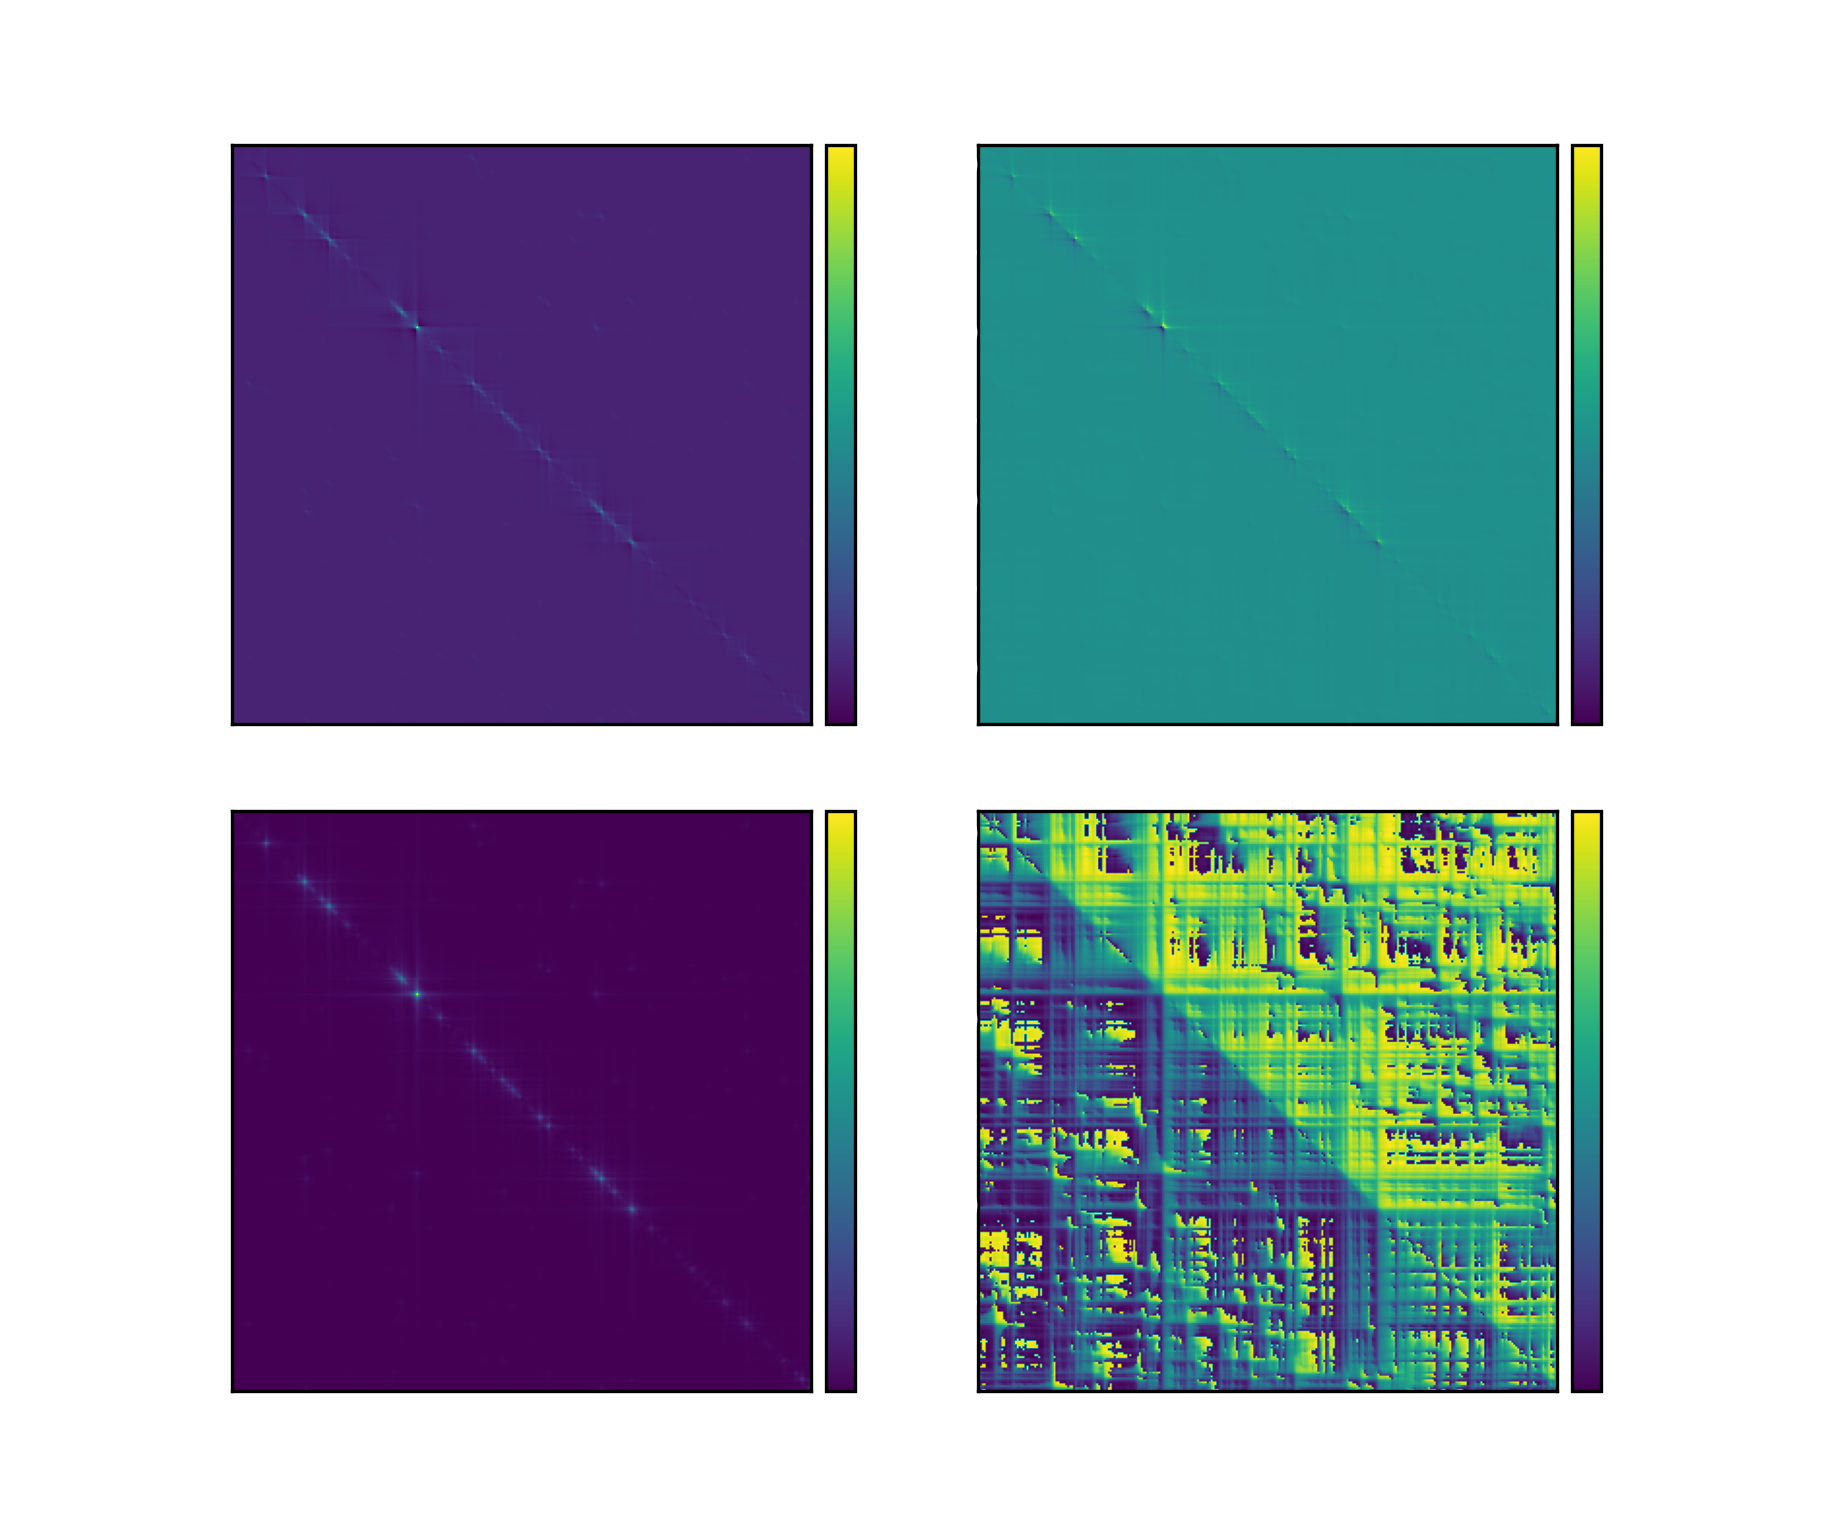

In [50]:
minPlt = 406.5   # THz
maxPlt = 407.1  # THz

# minPlt = nu_t_min   # THz
# maxPlt = nu_t_max  # THz

minInd_t = np.argmin(np.abs(nu_t-minPlt))
maxInd_t = np.argmin(np.abs(nu_t-maxPlt))

minInd_tau = np.argmin(np.abs(nu_tau+maxPlt))
maxInd_tau = np.argmin(np.abs(nu_tau+minPlt))

I_random6Plt = I_random6[minInd_tau:maxInd_tau,minInd_t:maxInd_t] - I_random6_unbranch[minInd_tau:maxInd_tau,minInd_t:maxInd_t]

I_random6_ReImAmPh = np.array([I_random6Plt.real, 
                               I_random6Plt.imag, 
                               np.sqrt(abs2(I_random6Plt)), 
                               phase(I_random6Plt)])

fig_random6 = slices_plots(I_random6_ReImAmPh, 
                           shared_title='I_random6 - I_random6_unbranch, ' 
                           'R_couple_Floor=' f'{R_couple_Floor:.0e}',
                           shared_title_y_position=0.95,
                           figure_shape=[2,2], 
                           figure_size=[6,5.5],
                           titles=[r'$\mathfrak{R} \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$', 
                                   r'$\mathfrak{I} \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$',
                                   r'$             \left |I_{rand6} (\nu_t, \nu_\tau) \right |$',
                                   r'$     \varphi \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$'],
                           horizontal_gap=0.15,
                           shared_y_label_x_position=0.02, 
                           shared_x_label_y_position=0.06,
                           EXTENT=(nu_t[minInd_t], 
                                   nu_t[maxInd_t], 
                                   nu_tau[minInd_tau], 
                                   nu_tau[maxInd_tau])
                          )

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_966/3137722074.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rho" failed type inference due to: Invalid use of type(CPUDispatcher(<function Delta_gs at 0x7f9d30559790>)) with parameters (float64, float64, float64, float64, float64)

During: resolving callee type: type(CPUDispatcher(<function Delta_gs at 0x7f9d30559790>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_966/3137722074.py (13)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_966/3137722074.py", line 13:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_966/3137722074.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "rho" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.Lifted

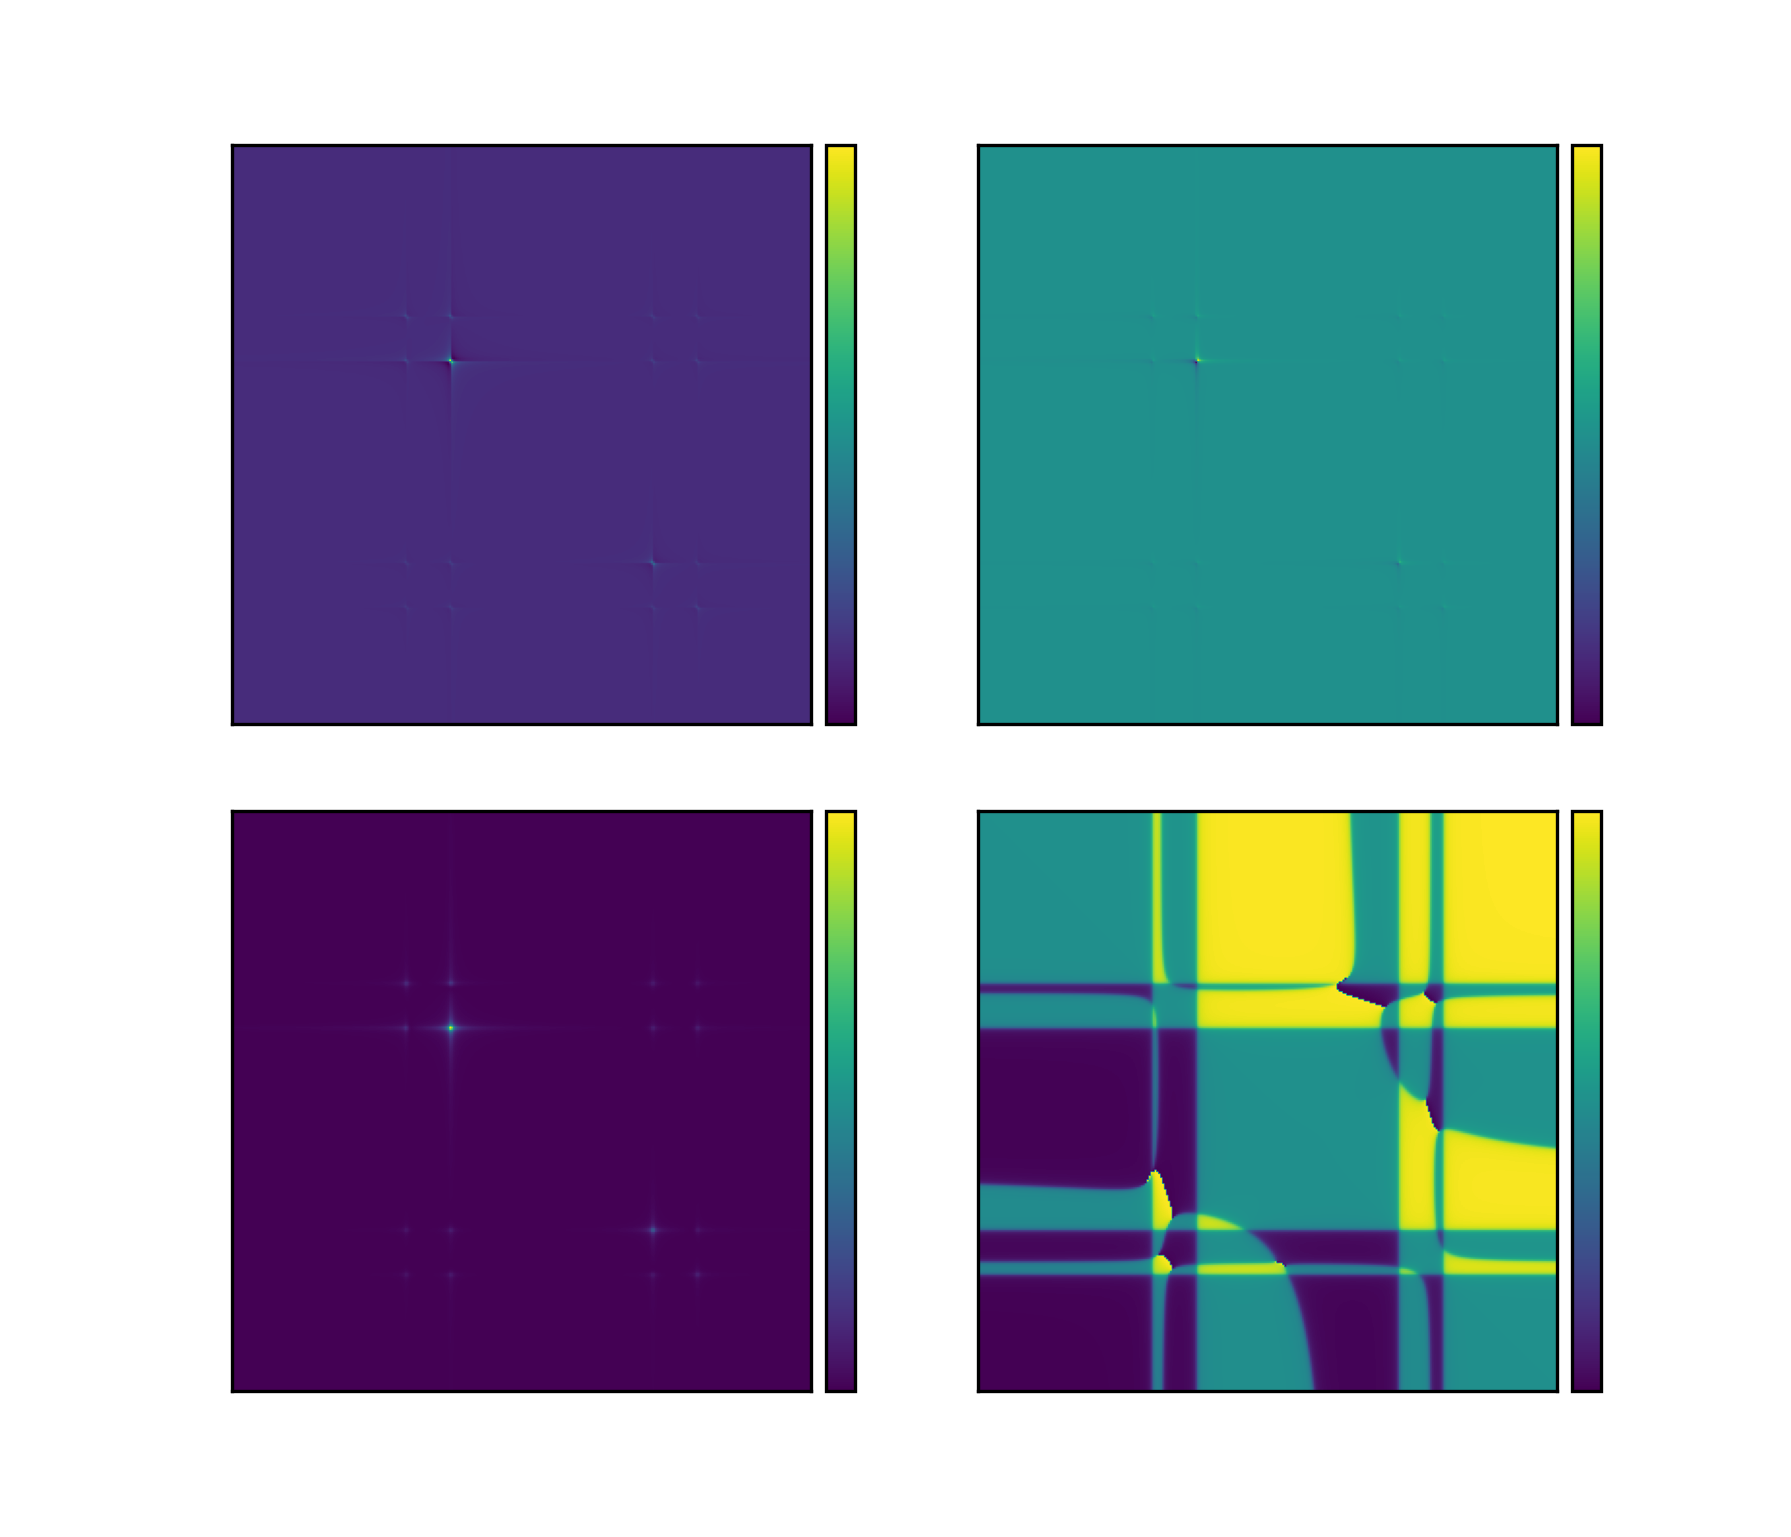

In [44]:
minPlt = 406.5   # THz
maxPlt = 407.1  # THz

# minPlt = nu_t_min   # THz
# maxPlt = nu_t_max  # THz

minInd_t = np.argmin(np.abs(nu_t-minPlt))
maxInd_t = np.argmin(np.abs(nu_t-maxPlt))

minInd_tau = np.argmin(np.abs(nu_tau+maxPlt))
maxInd_tau = np.argmin(np.abs(nu_tau+minPlt))

RHO = rho(nu_t_mesh, nu_tau_mesh)[minInd_tau:maxInd_tau,minInd_t:maxInd_t]

RHO_ReImAmPh = np.array([RHO.real, 
                               RHO.imag, 
                               np.sqrt(abs2(RHO)), 
                               phase(RHO)])

fig_random6 = slices_plots(RHO_ReImAmPh, 
                           shared_title='Lorentzians, StdDev_direc=' 
                           f'{StdDev_direc:.0e}, ' 'StdDev_shear=' f'{StdDev_shear:.0e}',
                           shared_title_y_position=0.95,
                           figure_shape=[2,2], 
                           figure_size=[6,5.5],
                           titles=[r'$\mathfrak{R} \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$', 
                                   r'$\mathfrak{I} \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$',
                                   r'$             \left |I_{rand6} (\nu_t, \nu_\tau) \right |$',
                                   r'$     \varphi \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$'],
                           horizontal_gap=0.15,
                           shared_y_label_x_position=0.02, 
                           shared_x_label_y_position=0.06,
                           EXTENT=(nu_t[minInd_t], 
                                   nu_t[maxInd_t], 
                                   nu_tau[minInd_tau], 
                                   nu_tau[maxInd_tau])
                          )

# Noise filter https://stackoverflow.com/questions/37598986/reducing-noise-on-data

# signal shifting right problem https://dsp.stackexchange.com/questions/19084/applying-filter-in-scipy-signal-use-lfilter-or-filtfilt

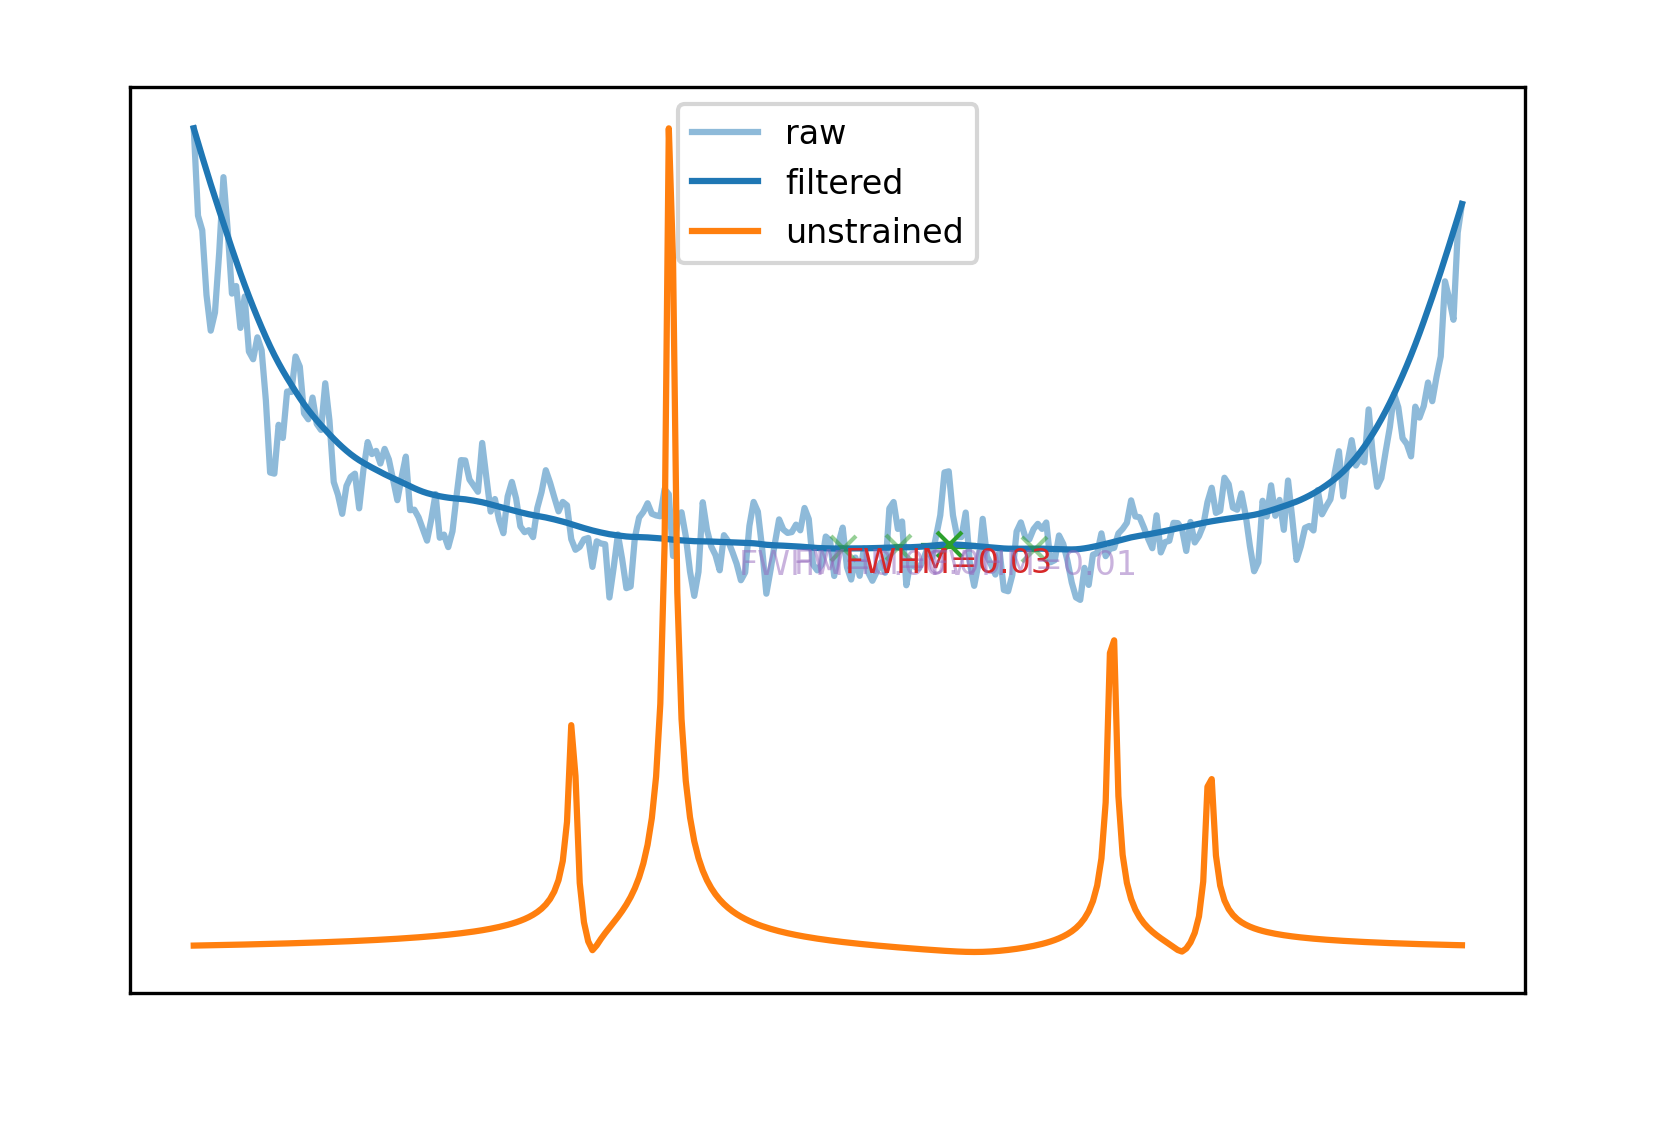

In [45]:
I_random6_proj = np.sqrt(abs2(np.sum(I_random6,
                                     axis=0)))  # Projecting onto nu_t axis

# I_random6_proj /= np.max(I_random6_proj)

n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1.

I_random6_proj_fill_amp = spsig.filtfilt(b, a, np.sqrt(abs2(I_random6_proj)))

peaks, _ = spsig.find_peaks(I_random6_proj_fill_amp)
results_half = spsig.peak_widths(I_random6_proj_fill_amp,
                                 peaks,
                                 rel_height=0.5)

unstrained = np.sqrt(abs2(np.sum(rho(nu_t_mesh, nu_tau_mesh),
                                 axis=0)))  # unstrained
unstrained *= np.max(I_random6_proj_fill_amp) / np.max(unstrained)

plt.figure()
plt.plot(nu_t, I_random6_proj, alpha=0.5, label='raw')
plt.plot(nu_t, I_random6_proj_fill_amp, c='C0',
         label='filtered')  # smooth by filter
plt.plot(nu_t, unstrained, label='unstrained')

for i in range(len(peaks)):

    if i == np.argmax(results_half[0]):
        color='C3'
        Alpha=1
    else:
        color='C4'
        Alpha=0.5

    plt.plot(nu_t[peaks[i]],
             I_random6_proj_fill_amp[peaks[i]],
             "x",
             c='C2',
             alpha=Alpha)
    plt.hlines(results_half[1][i],
               results_half[2][i] / res * (nu_t_max - nu_t_min) + nu_t_min,
               results_half[3][i] / res * (nu_t_max - nu_t_min) + nu_t_min,
               color="C2",
               alpha=Alpha)
    plt.text(nu_t[peaks[i]],
             results_half[1][i],
             f'FWHM={results_half[0][i]/res*(nu_t_max-nu_t_min) :.2f}',
             c=color,
             alpha=Alpha,
             ha='center',
             va='top')
plt.legend(labelcolor='k')
plt.title(
    r'Projection of $\left |I_{random6} (\nu_t, \nu_\tau) \right |$ onto $\nu_t$, StdDev_direc=' 
    f'{StdDev_direc:.0e}, ' 'StdDev_shear=' f'{StdDev_shear:.0e}')
plt.xlabel(r'Third-order frequency, $\nu_t$ (THz)')
plt.ylabel(r'Signal (arb. units)')
plt.show()

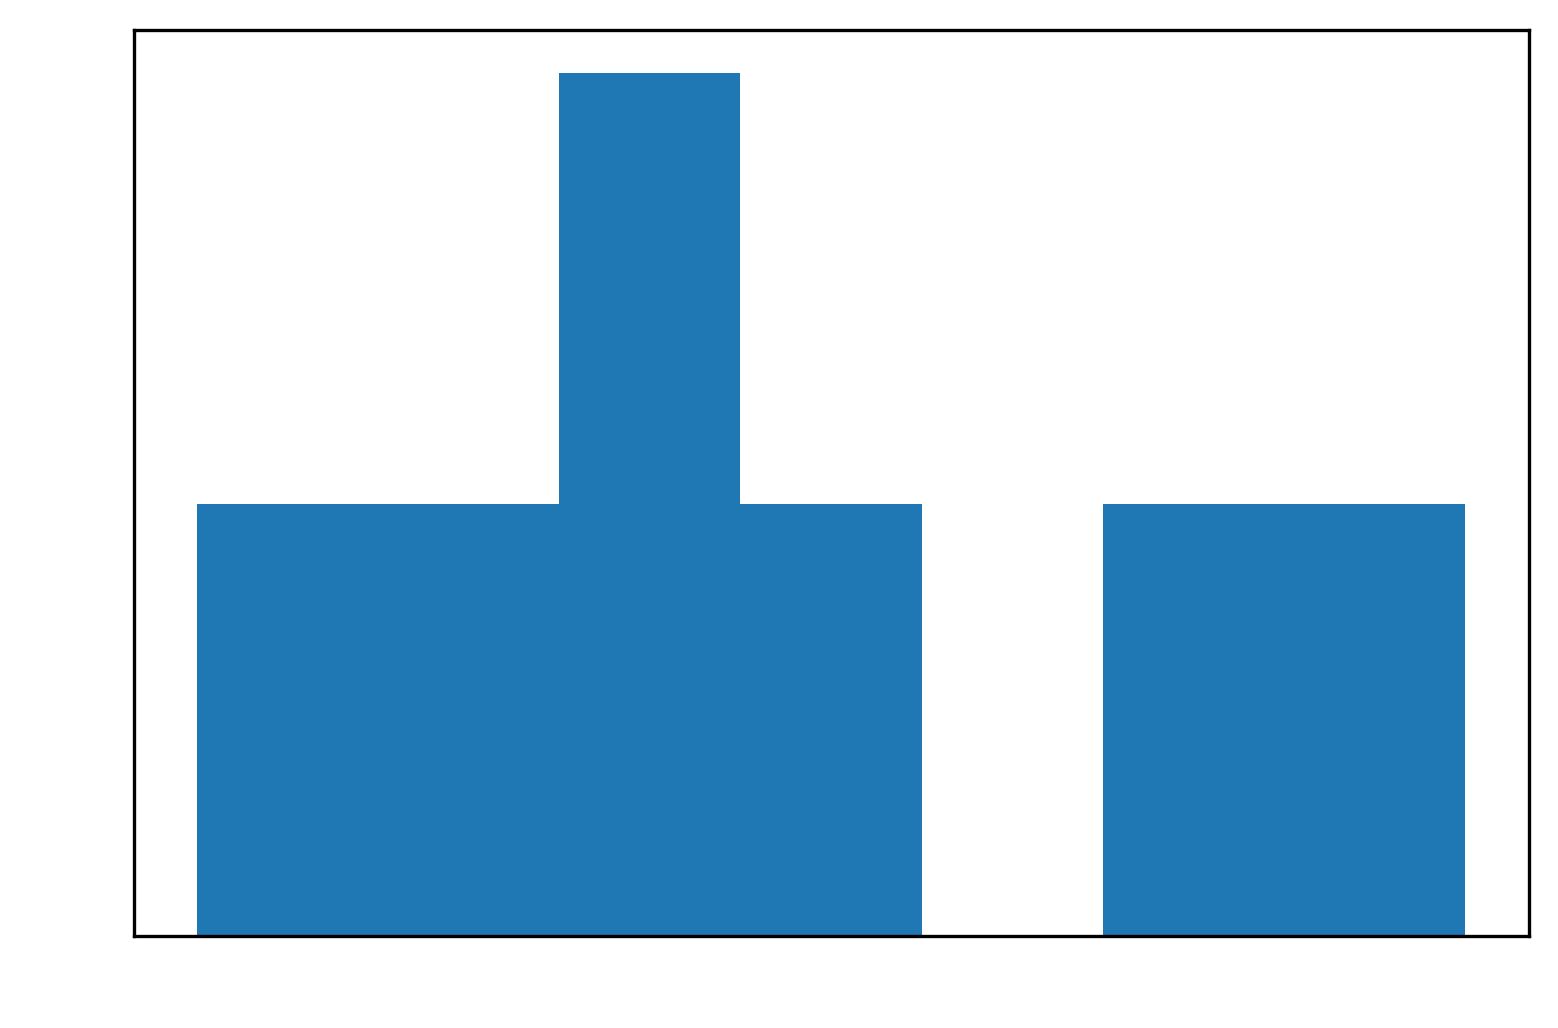

In [46]:
FWHMdata_MC1e4_strn2p425en4 = np.array([1.82, 1.71])

FWHMdata_MC1e4_strn2p45en4 = np.array([1.86, 1.86])

FWHMdata_MC1e4_strn2p4en4 = np.array([1.72])

FWHMdata_MC1e4_strn2p35en4 = np.array([1.76])

FWHMdata_MC1e4_strn2p25en4 = np.array([1.76])

FWHMdata_MC1e4_strn2p5en4 = np.array([1.82, 1.83, 1.79, 1.88, 1.90, 1.77, 1.81])

FWHMdata_MC5e3_strn2p5en4 = np.array([1.67, 1.79, 1.83, 1.69, 2.1, 1.88, 1.92, 2.02, 1.78, 1.89, 2.04])
plt.hist(FWHMdata_MC1e4_strn2p5en4, bins=len(FWHMdata_MC1e4_strn2p5en4))
plt.show()

In [47]:
np.mean(FWHMdata_MC1e4_strn2p5en4)

1.8285714285714287

In [49]:
np.mean(FWHMdata_MC5e3_strn2p5en4)

1.8736363636363635